# Assignment 8

Develop a model for 20 news groups dataset from scikit-learn. Select 20% of data for test set.  

Develop metric learning model with siamese network [3 points] and triplet loss [3 points] (from seminar). 
Use KNN and LSH (any library for approximate nearest neighbor search) for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors. 

Your quality metric = accuracy score [2 points if acc > 0.8 ]

In [0]:
!pip install -U sentence-transformers
!pip install annoy

In [0]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import re
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import spacy
spacy_en = spacy.load('en')

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
nltk.download('punkt')
nltk.download('stopwords')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

from annoy import AnnoyIndex
from scipy.spatial import cKDTree
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Stuff

In [0]:
df = fetch_20newsgroups(subset='all')
X = df['data']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=23)

len(X_train), len(X_test), len(y_train), len(y_test)

(15076, 3770, 15076, 3770)

In [0]:
def remove_stop_words(tokens, stopwords=stopwords):
    return [token for token in tokens if not token in stopwords]

    return tokens_cleaned
def tokenizer(text):
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

def clean_data(text, tokenizer=tokenizer):
    text = re.sub(r'-{2,10}\s.{2,20}\s-{2,25}', '', text)
    text = re.sub(r'\n#', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = remove_stop_words(tokenizer(text))
    text = ' '.join(text)
    return text

def clean_tqdm():
    for instance in list(tqdm._instances): 
        tqdm._decr_instances(instance)

# Getting Embeddings

In [0]:
# https://paperswithcode.com/paper/sentence-bert-sentence-embeddings-using
# https://github.com/UKPLab/sentence-transformers

In [0]:
model = SentenceTransformer('bert-base-wikipedia-sections-mean-tokens')

In [430]:
clean_tqdm()
sentences_train = [clean_data(text) for text in X_train]
embeddings_train = model.encode(sentences_train, show_progress_bar=True)

sentences_test = [clean_data(text) for text in X_test]
embeddings_test = model.encode(sentences_test, show_progress_bar=True)


Batches: 100%|██████████| 472/472 [01:09<00:00,  2.01it/s]


In [431]:
x_train = torch.FloatTensor(embeddings_train)
x_test = torch.FloatTensor(embeddings_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

x_train.size(), x_test.size(), y_train.size(), y_test.size()

(torch.Size([15076, 768]),
 torch.Size([3770, 768]),
 torch.Size([15076]),
 torch.Size([3770]))

In [0]:
def get_triplets(embeddings, y):
    """
    Рандомно выбирается эмбеддинг совпадающего класса (добавляется в pos) и эмбеддинг несовпадающего (добавляется в neg).
    """
    pos = []
    neg = []
    for ind, anchor in enumerate(embeddings):
        pos.append(embeddings[np.random.choice(np.where(y == y[ind])[0])])
        neg.append(embeddings[np.random.choice(np.where(y != y[ind])[0])])
    return torch.FloatTensor(pos), torch.FloatTensor(neg)

In [0]:
pos_train, neg_train = get_triplets(embeddings_train, y_train)
pos_test, neg_test = get_triplets(embeddings_test, y_test)

assert pos_train.size() == neg_train.size() == x_train.size()
assert pos_test.size() == neg_test.size() == x_test.size()

In [0]:
batch_size = 2048
train_loader = DataLoader(TensorDataset(x_train, pos_train, neg_train,  y_train), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(x_test, pos_test, neg_test, y_test), batch_size=batch_size)

In [435]:
for el in test_loader:
    print(type(el), len(el))
    print(el[0].size(), el[1].size(), el[2].size(), el[3].size())
    break

<class 'list'> 4
torch.Size([2048, 768]) torch.Size([2048, 768]) torch.Size([2048, 768]) torch.Size([2048])


# Model

In [0]:
def triplet_loss(anchor_embed, pos_embed, neg_embed, margin=.5):
    # https://pytorch.org/docs/stable/nn.html#torch.nn.TripletMarginLoss
    # https://github.com/UKPLab/sentence-transformers/blob/9b94d3fae98970ccdf380139542d93011bb984ea/sentence_transformers/losses/TripletLoss.py#L8

    # positive = F.pairwise_distance(anchor_embed, pos_embed, p=2)  # Варианты для euclidian distance (loss хуже)
    # negative = F.pairwise_distance(anchor_embed, neg_embed, p=2)

    positive = 1 - F.cosine_similarity(anchor_embed, pos_embed)
    negative = 1 - F.cosine_similarity(anchor_embed, neg_embed)
    differ = positive - negative + margin
    return F.relu(differ).mean()
    
class Tripletnet(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size):
        super(Tripletnet, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def branch(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.out(x)
        return x

    def forward(self, batch):
        anchor, pos, neg = batch[0], batch[1], batch[2]
        
        anchor = self.branch(anchor)
        pos = self.branch(pos)
        neg = self.branch(neg)
        out = triplet_loss(anchor, pos, neg)
        return out

model = Tripletnet(input_size=768, hidden_size=128, output_size=256)
optimizer = optim.Adam(model.parameters())

In [0]:
train_losses = []
valid_losses = []

def _train_epoch(model, iterator, optimizer, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        loss = model(batch)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        train_losses.append(running_loss)
        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

def _test_epoch(model, iterator):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            loss = model(batch)
            epoch_loss += loss.data.item()
            valid_losses.append(loss)

    return epoch_loss / n_batches

def nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, epoch)
        valid_loss = _test_epoch(model, valid_iterator)
       # scheduler.step(valid_loss)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)

nn_train(model, train_loader, test_loader, optimizer, n_epochs=100)

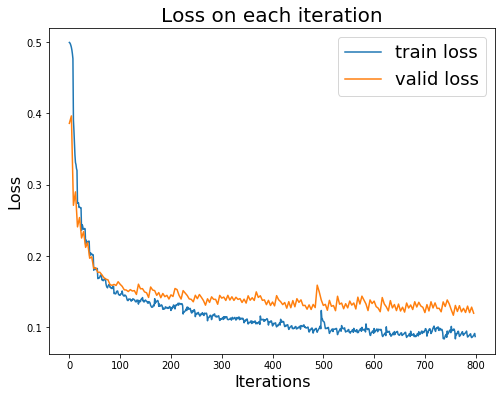

In [438]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Final Predicion

In [439]:
DIM = 256
N_TREES = 1000

f = DIM
t = AnnoyIndex(f, "manhattan")
for i in range(x_train.size()[0]):
    v = model.branch(x_train[i])
    t.add_item(i, v)
t.build(N_TREES)
t.save('justincase.ann')

True

In [440]:
clean_tqdm()
count_true = 0

_true = []
_pred = []
for i, vector in tqdm(enumerate(x_test)):

    nn_ids = np.array(t.get_nns_by_vector(model.branch(vector), 2000))
    neighbor_vectors = np.take(x_train, nn_ids, axis=0).tolist()
    
    neighbor_vectors_y = np.take(y_train, nn_ids).tolist()
    pred = neighbor_vectors[cKDTree(neighbor_vectors).query(vector,k=1)[1]]
    ind_pred = neighbor_vectors.index(pred)
    
    
    # Блок для подбора по макс кол-ву
    inds = cKDTree(neighbor_vectors).query(vector,k=15)[1]
    pred = [neighbor_vectors[ind] for ind in inds]
    pred_y = [neighbor_vectors.index(p) for p in pred]
    inds = [neighbor_vectors_y[p] for p in pred_y]   
    _pred.append(most_frequent(inds))
    # Конец Блока

    _true.append(y_test[i].item())
    # _pred.append(neighbor_vectors_y[ind_pred])
    if y_test[i] == neighbor_vectors_y[ind_pred]: # Сравниваем с тру классом
        count_true += 1

    if i==100:
        print(count_true)
        break

print('Accuracy score: {}'.format(count_true/len(x_test)))

100it [00:35,  2.79it/s]

83
Accuracy score: 0.022015915119363395


In [441]:
from sklearn.metrics import accuracy_score
accuracy_score(_true, _pred)

0.7128712871287128

In [0]:
# from sklearn.neighbors import NearestNeighbors

# vec_predicted = np.array([model.branch(vector).detach().numpy() for vector in x_test])

# nbrs = NearestNeighbors(n_neighbors=50).fit(vec_predicted)
# distances, inds = nbrs.kneighbors(vec_predicted)

In [0]:
# for ind, vector in enumerate(vec_predicted):
#     vector_dists = distances[i]#[1:]
#     vector_ids = distances[i]#[1:]


In [0]:
from sklearn.neighbors import NearestNeighbors

predicted = np.array([model.branch(vector).detach().numpy() for vector in x_test])

nbrs = NearestNeighbors(n_neighbors=50).fit(predicted)
distances, indices = nbrs.kneighbors(predicted)

predict_df = pd.DataFrame(columns=['target', 'vec'])
predict_df['target'] = y_test
predict_df['vec'] = list(predicted)
predicted_classes = []
count = 0
for i, row in predict_df.iterrows():
    distances_to_classes = [100]*20
    distances_i = distances[i][1:] # Дистанции до айтема
    indices_i = indices[i][1:] # Индексы ближайших объектов
    # print(indices_i)
    # print(type(indices_i))

    labels = [predict_df['target'][ind] for ind in indices_i]
    # print(labels)
    # break
    # print('DIST')
    # print(distances_i)
    # break

    
    def most_frequent(List): 
        return max(set(List), key = List.count) 
    
    
    
    
    
    index_min = indices_i[np.argmin(np.array(distances_i))]

    class_min = most_frequent(labels)
    #print(index_min)
    # class_min = predict_df['target'][index_min]

    for n_i, n_d in enumerate(distances_i):
        class_n = predict_df['target'][indices_i[n_i]]
        #print(class_n)
        if distances_to_classes[int(class_n)] == 100 :
            distances_to_classes[int(class_n)] = n_d
        else:
            distances_to_classes[int(class_n)] += n_d
    if 0. in distances_to_classes:
        count += 1
    class_i = float(distances_to_classes.index(min(distances_to_classes)))

    #print(class_min, class_i)
    #assert class_min == class_i

    predicted_classes.append(class_min)

In [443]:
predicted_classes[:5]

[18.0, 8.0, 10.0, 10.0, 15.0]

In [444]:
y_test[:5]

tensor([18.,  8.,  9., 10.,  0.])

In [445]:
accuracy_score(y_true = y_test, y_pred=predicted_classes)

0.6119363395225464

In [446]:
count

0